![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/16.Adverse_Drug_Event_ADE_NER_and_Classifier.ipynb)

# Adverse Drug Event (ADE) Pretrained NER and Classifier Models

`ADE NER`: Extracts ADE and DRUG entities from clinical texts.

`ADE Classifier`: Classify if a sentence is ADE-related (`True`) or not (`False`)

We use several datasets to train these models:

- Twitter dataset, which is used in paper "`Deep learning for pharmacovigilance: recurrent neural network architectures for labeling adverse drug reactions in Twitter posts`" (https://pubmed.ncbi.nlm.nih.gov/28339747/)
- ADE-Corpus-V2, which is used in paper "`An Attentive Sequence Model for Adverse Drug Event Extraction from Biomedical Text`" (https://arxiv.org/abs/1801.00625) and available online: https://sites.google.com/site/adecorpus/home/document.
- CADEC dataset, which is used in paper `Cadec: A corpus of adverse drug event annotations` (https://pubmed.ncbi.nlm.nih.gov/25817970)

In [ ]:
import os

jsl_secret = os.getenv('SECRET')

import sparknlp
sparknlp_version = sparknlp.version()
import sparknlp_jsl
jsl_version = sparknlp_jsl.version()

print (jsl_secret)

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(jsl_secret,params=params)

print (sparknlp.version())
print (sparknlp_jsl.version())

3.1.2
3.1.2


## ADE Classifier Pipeline (with a pretrained model)

`True` : The sentence is talking about a possible ADE

`False` : The sentences doesn't have any information about an ADE.



### ADE Classifier with BioBert

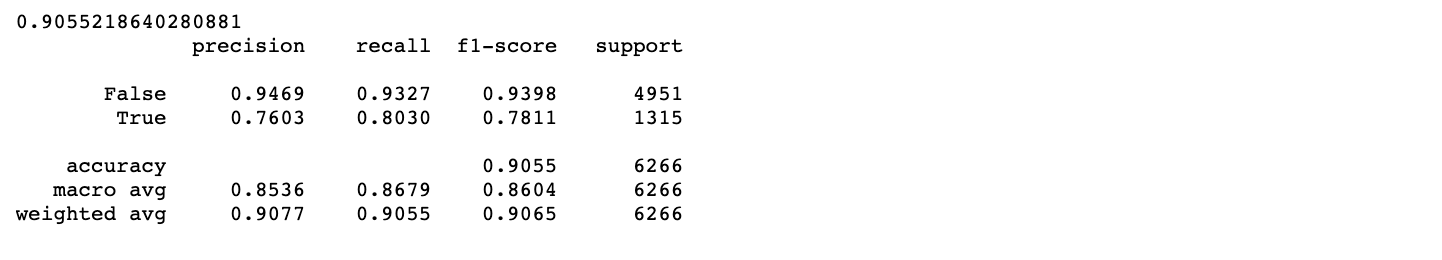

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")\
      .setMaxSentenceLength(512)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["sentence", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")\
      .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_biobert", "en", "clinical/models")\
      .setInputCols(["sentence", "sentence_embeddings"]) \
      .setOutputCol("class")

ade_clf_pipeline = Pipeline(
    stages=[documentAssembler, 
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            classsifierdl])


empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_clf_model = ade_clf_pipeline.fit(empty_data)

ade_lp_pipeline = LightPipeline(ade_clf_model)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_ade_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [ ]:
text = "I feel a bit drowsy & have a little blurred vision after taking an insulin"

ade_lp_pipeline.annotate(text)['class'][0]

'True'

In [ ]:
text="I just took an Advil and have no gastric problems so far."

ade_lp_pipeline.annotate(text)['class'][0]

'False'

As you can see `gastric problems` is not detected as `ADE` as it is in a negative context. So, classifier did a good job detecting that.

In [ ]:
text="I just took a Metformin and started to feel dizzy."

ade_lp_pipeline.annotate(text)['class'][0]

'True'

In [ ]:
t='''
Always tired, and possible blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldn't find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.
'''

ade_lp_pipeline.annotate(t)['class'][0]


'True'

In [ ]:
texts = ["I feel a bit drowsy & have a little blurred vision, after taking a pill.",
"I've been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it.",
"Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes.",
"So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50."]

for text in texts:

  result = ade_lp_pipeline.annotate(text)

  print (result['class'][0])


True
False
True
False


### ADE Classifier trained with conversational (short) sentences

This model is trained on short, conversational sentences related to ADE and is supposed to do better on the text that is short and used in a daily context.

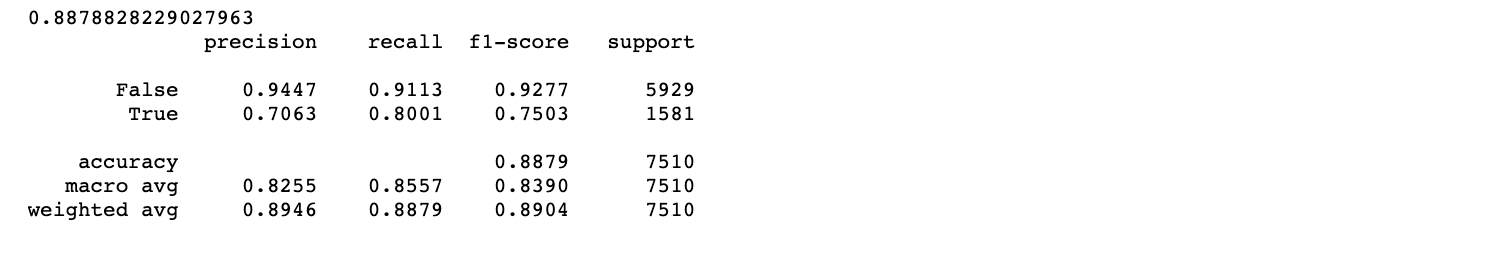

In [ ]:
conv_classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_conversational_biobert", "en", "clinical/models")\
            .setInputCols(["sentence", "sentence_embeddings"]) \
            .setOutputCol("class")

conv_ade_clf_pipeline = Pipeline(
    stages=[documentAssembler, 
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            conv_classsifierdl])

empty_data = spark.createDataFrame([[""]]).toDF("text")

conv_ade_clf_model = conv_ade_clf_pipeline.fit(empty_data)

conv_ade_lp_pipeline = LightPipeline(conv_ade_clf_model)

classifierdl_ade_conversational_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [ ]:
text = "after taking a pill, he denies any pain"

conv_ade_lp_pipeline.annotate(text)['class'][0]

'False'

## ADE NER

Extracts `ADE` and `DRUG` entities from text.

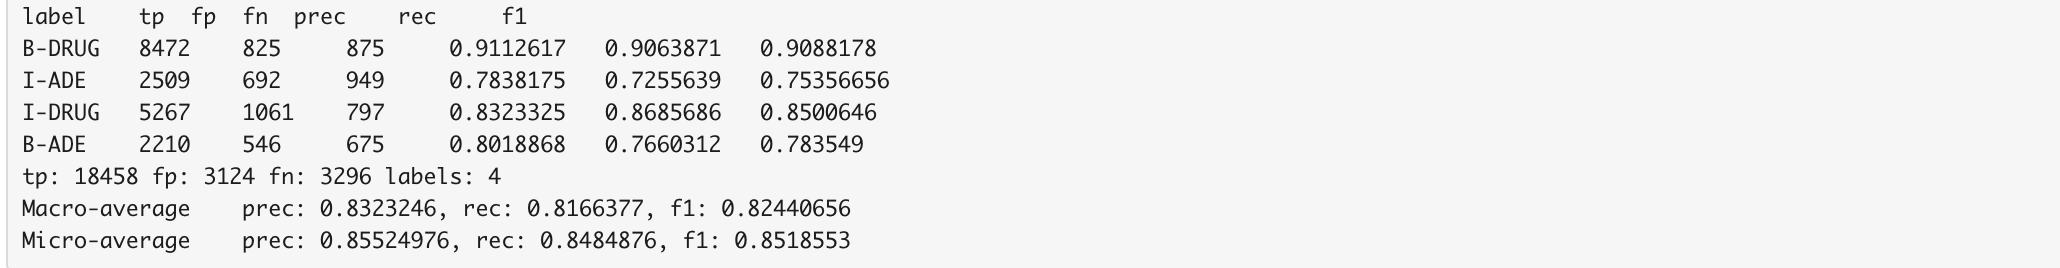

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ade_ner = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

ade_ner_lp = LightPipeline(ade_ner_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_ade_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
light_result = ade_ner_lp.fullAnnotate("I feel a bit drowsy & have a little blurred vision, so far no gastric problems. I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it. Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes. So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50.")

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,bit drowsy,ADE,9,18
1,little blurred vision,ADE,29,49
2,Arthrotec,DRUG,95,103


As you can see `gastric problems` is not detected as `ADE` as it is in a negative context. So, NER did a good job ignoring that.

#### ADE NER with Bert embeddings

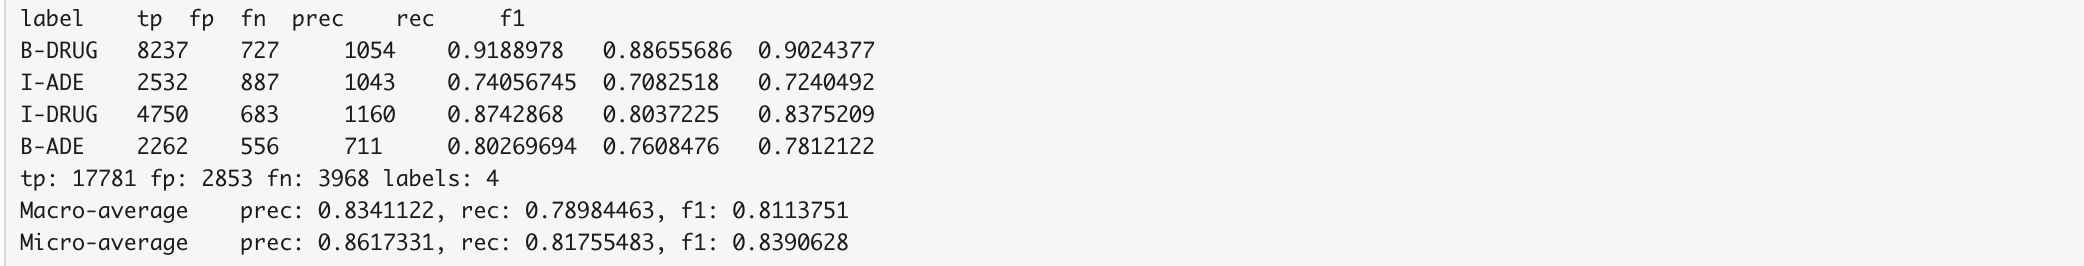

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")
  
ade_ner_bert = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model_bert = ner_pipeline.fit(empty_data)

ade_ner_lp_bert = LightPipeline(ade_ner_model_bert)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_ade_biobert download started this may take some time.
Approximate size to download 15.3 MB
[OK!]


In [ ]:
light_result = ade_ner_lp_bert.fullAnnotate("I feel a bit drowsy & have a little blurred vision, so far no gastric problems. I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it. Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes. So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50.")

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,drowsy,ADE,13,18
1,blurred vision,ADE,36,49
2,gastric problems,ADE,62,77
3,Arthrotec,DRUG,95,103
4,gp's,DRUG,269,272
5,pains,ADE,413,417


Looks like Bert version of NER returns more entities than clinical embeddings version.

## NER and Classifier combined with AssertionDL Model

In [ ]:
assertion_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ass_ner_chunk")\
    .setWhiteList(['ADE'])

biobert_assertion = AssertionDLModel.pretrained("assertion_dl_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "ass_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter,
    assertion_ner_converter,
    biobert_assertion])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ass_ner_model_bert = assertion_ner_pipeline.fit(empty_data)

ade_ass_ner_model_lp_bert = LightPipeline(ade_ass_ner_model_bert)

assertion_dl_biobert download started this may take some time.
Approximate size to download 3 MB
[OK!]


In [ ]:
import pandas as pd
text = "I feel a bit drowsy & have a little blurred vision, so far no gastric problems. I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it. Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes. So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50."

print (text)

light_result = ade_ass_ner_model_lp_bert.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ass_ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

I feel a bit drowsy & have a little blurred vision, so far no gastric problems. I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it. Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes. So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50.


,chunks,entities,assertion
0,drowsy,ADE,present
1,blurred vision,ADE,present
2,gastric problems,ADE,absent
3,pains,ADE,present


Looks great ! `gastric problems` is detected as `ADE` and `absent`

## ADE models applied to Spark Dataframes

In [ ]:
import pyspark.sql.functions as F

! wget -q	https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/sample_ADE_dataset.csv

ade_DF = spark.read\
                .option("header", "true")\
                .csv("./sample_ADE_dataset.csv")\
                .filter(F.col("label").isin(['True','False']))

ade_DF.show(truncate=50)

+--------------------------------------------------+-----+
|                                              text|label|
+--------------------------------------------------+-----+
|Do U know what Meds are R for bipolar depressio...|False|
|# hypercholesterol: Because of elevated CKs (pe...| True|
|Her weight, respirtory status and I/O should be...|False|
|* DM - Pt had several episodes of hypoglycemia ...| True|
|We report the case of a female acromegalic pati...| True|
|2 . Calcipotriene 0.005% Cream Sig: One (1) App...|False|
|Always tired, and possible blood clots. I was o...| True|
|A difference in chemical structure between thes...|False|
|10 . She was left on prednisone 20mg qd due to ...|False|
|The authors suggest that risperidone may increa...| True|
|- Per oral maxillofacial surgery there is no ev...|False|
|@marionjross Cipro is just as bad! Stay away fr...|False|
|A young woman with epilepsy had tonic-clonic se...| True|
|Intravenous methotrexate is an effective adjunc...|Fals

**With BioBert version of NER** (will be slower but more accurate)

In [ ]:
import pyspark.sql.functions as F

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['ADE'])

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    bert_embeddings,
    ade_ner_bert,
    ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

result = ade_ner_model.transform(ade_DF)

sample_df = result.select('text','ner_chunk.result')\
                  .toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>0).toPandas()

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [ ]:
sample_df.sample(20)

,text,ADE_phrases
10,A fatal massive pulmonary embolus developed in a patient treated with streptokinase for acute deep vein thrombosis.,[fatal massive pulmonary embolus]
17,Hepatic reactions to cyclofenil.,[Hepatic reactions]
6,Intravenous methotrexate is an effective adjunct to steroid therapy in the treatment of steroid-resistant or life-threatening dermatomyositis-polyositis or dermatomyositis-polymyositis complicated by severe steroid-related effects.,"[life-threatening dermatomyositis-polyositis, dermatomyositis-polymyositis]"
29,Treatment of anticholinergic-induced ileus with neostigmine.,[ileus]
27,Succinylcholine-induced hyperkalemia in a patient with mucositis secondary to chemotherapy.,[hyperkalemia]
5,A young woman with epilepsy had tonic-clonic seizures during antineoplastic therapy with adriamycin and cisplatin.,[tonic-clonic seizures]
16,Electrocardiographic findings and laboratory data indicated a diagnosis of acute myocardial infarction due to the L-thyroxine therapy.,[acute myocardial infarction]
9,# thrombocytopenia: Secondary to chemotherapy and MDS/AML concerns.,[thrombocytopenia]
26,"With itraconazole, hepatotoxic reactions have only very rarely been reported, and histologic data are lacking.",[hepatotoxic reactions]
28,"Lipitor is the only prescription drug I take and have taken it for four years now. I have noticed I am gaining excess weight even though I am not eating more. My stomach is bloated, with excess gas (although could be the weight gain?). I also am experiencing increased memory loss, and fatigue, but then I rarely sleep well (due to night sweats) since I went through menopause ten years ago. I think some of my symptoms are related to being post menopausal rather than from the Lipitor.","[gaining excess weight, stomach is bloated, memory loss, fatigue, night sweats]"


**Doing the same with clinical embeddings version** (faster results)

In [ ]:
import pyspark.sql.functions as F

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['ADE'])

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

result = ade_ner_model.transform(ade_DF)

result.select('text','ner_chunk.result')\
.toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>0)\
.show(truncate=70)


+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                  text|                                                           ADE_phrases|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|# hypercholesterol: Because of elevated CKs (peaked at 819) the pat...|                                                        [elevated CKs]|
|We report the case of a female acromegalic patient in whom multiple...|                                           [multiple hepatic adenomas]|
|Always tired, and possible blood clots. I was on Voltaren for about...|                      [blood clots that traveled to my eye, back pain]|
|The authors suggest that risperidone may increase affect in patient...|                                                     [increase a

### Creating sentence dataframe (one sentence per row) and getting ADE entities and categories

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")\
      .setExplodeSentences(True)

tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["sentence", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")\
      .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_biobert", "en", "clinical/models")\
      .setInputCols(["sentence", "sentence_embeddings"]) \
      .setOutputCol("class")\
      .setStorageRef('biobert_pubmed_base_cased')

ade_ner = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")
  
ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")\
      .setWhiteList(['ADE'])

ner_clf_pipeline = Pipeline(
    stages=[documentAssembler, 
            sentenceDetector,
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            classsifierdl,
            ade_ner,
            ner_converter])

ade_Sentences = ner_clf_pipeline.fit(ade_DF)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_ade_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]
ner_ade_biobert download started this may take some time.
Approximate size to download 15.3 MB
[OK!]


In [ ]:
import pyspark.sql.functions as F

ade_Sentences.transform(ade_DF).select('sentence.result','ner_chunk.result','class.result')\
.toDF('sentence','ADE_phrases','is_ADE').show(truncate=60)

+------------------------------------------------------------+---------------------------------------------+-------+
|                                                    sentence|                                  ADE_phrases| is_ADE|
+------------------------------------------------------------+---------------------------------------------+-------+
|         [Do U know what Meds are R for bipolar depression?]|                                           []|[False]|
|         [Currently #FDA approved #quetiapine AKA #Seroquel]|                                           []|[False]|
|[# hypercholesterol: Because of elevated CKs (peaked at 8...|                               [elevated CKs]|[False]|
|[Her weight, respirtory status and I/O should be monitore...|                                           []|[False]|
|[* DM - Pt had several episodes of hypoglycemia on lantus...|                               [hypoglycemia]| [True]|
|[We report the case of a female acromegalic patient in wh...|  

## Creating a pretrained pipeline with ADE NER, Assertion and Classifer

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ade_ner = MedicalNerModel.pretrained("ner_ade_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    .setStorageRef('biobert_pubmed_base_cased')

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

assertion_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ass_ner_chunk")\
    .setWhiteList(['ADE'])

biobert_assertion = AssertionDLModel.pretrained("assertion_dl_biobert", "en", "clinical/models") \
    .setInputCols(["sentence", "ass_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")\
    .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_conversational_biobert", "en", "clinical/models")\
    .setInputCols(["sentence", "sentence_embeddings"]) \
    .setOutputCol("class")

ade_clf_pipeline = Pipeline(
    stages=[documentAssembler, 
            tokenizer,
            bert_embeddings,
            ade_ner,
            ner_converter,
            assertion_ner_converter,
            biobert_assertion,
            embeddingsSentence,
            classsifierdl])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_clf_model = ade_clf_pipeline.fit(empty_data)

ade_ner_clf_pipeline = LightPipeline(ade_ner_clf_model)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_ade_biobert download started this may take some time.
Approximate size to download 15.3 MB
[OK!]
assertion_dl_biobert download started this may take some time.
Approximate size to download 3 MB
[OK!]
classifierdl_ade_conversational_biobert download started this may take some time.
Approximate size to download 21.8 MB
[OK!]


In [ ]:
classsifierdl.getStorageRef()

'biobert_pubmed_base_cased'

In [ ]:
text = 'Always tired, and possible blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.'

light_result = ade_ner_clf_pipeline.fullAnnotate(text)

print (light_result[0]['class'][0].metadata)

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end})

df

{'sentence': '0', 'False': '0.018514052', 'True': '0.9814859'}


,chunks,entities,begin,end
0,tired,ADE,7,11
1,blood clots,ADE,27,37
2,Voltaren,DRUG,49,56
3,stroke,ADE,110,115
4,blood clots that traveled to my eye,ADE,125,159
5,voltaren,DRUG,301,308
6,tylonol,DRUG,548,554


In [ ]:
import pandas as pd

text = 'I have always felt tired, but no blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.'

print (text)

light_result = ade_ass_ner_model_lp_bert.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ass_ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

I have always felt tired, but no blood clots. I was on Voltaren for about 4 years and all of the sudden had a minor stroke and had blood clots that traveled to my eye. I had every test in the book done at the hospital, and they couldnt find anything. I was completley healthy! I am thinking it was from the voltaren. I have been off of the drug for 8 months now, and have never felt better. I started eating healthy and working out and that has help alot. I can now sleep all thru the night. I wont take this again. If I have the back pain, I will pop a tylonol instead.


,chunks,entities,assertion
0,tired,ADE,present
1,blood clots,ADE,absent
2,stroke,ADE,present
3,blood clots that traveled to my eye,ADE,present
4,completley healthy,ADE,present


In [ ]:
result = ade_ner_clf_pipeline.annotate('I just took an Advil 100 mg and it made me drowsy')

print (result['class'])
print(list(zip(result['token'],result['ner'])))

['False']
[('I', 'O'), ('just', 'O'), ('took', 'O'), ('an', 'O'), ('Advil', 'B-DRUG'), ('100', 'O'), ('mg', 'O'), ('and', 'O'), ('it', 'O'), ('made', 'O'), ('me', 'O'), ('drowsy', 'B-ADE')]


In [ ]:
ade_ner_clf_model.save('ade_pretrained_pipeline')

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

ade_pipeline = PretrainedPipeline.from_disk('ade_pretrained_pipeline')

ade_pipeline.annotate('I just took an Advil 100 mg then it made me drowsy')

{'ass_ner_chunk': ['drowsy'],
 'assertion': ['conditional'],
 'class': ['True'],
 'embeddings': ['I',
  'just',
  'took',
  'an',
  'Advil',
  '100',
  'mg',
  'then',
  'it',
  'made',
  'me',
  'drowsy'],
 'ner': ['O', 'O', 'O', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ADE'],
 'ner_chunk': ['Advil', 'drowsy'],
 'sentence': ['I just took an Advil 100 mg then it made me drowsy'],
 'sentence_embeddings': ['I just took an Advil 100 mg then it made me drowsy'],
 'token': ['I',
  'just',
  'took',
  'an',
  'Advil',
  '100',
  'mg',
  'then',
  'it',
  'made',
  'me',
  'drowsy']}

In [ ]:
ade_pipeline.model.stages

[DocumentAssembler_cf2609466f78,
 REGEX_TOKENIZER_9dc449a9e85b,
 BERT_EMBEDDINGS_c6741c518b81,
 MedicalNerModel_4fc5b46ae2cf,
 NerConverter_172c4da72592,
 NerConverter_283c3e0f4480,
 ASSERTION_DL_2f4db8443148,
 SentenceEmbeddings_e6b3ad19b1f7,
 ClassifierDLModel_6edc7e323980]

## Pretrained ADE Pipeline

A pipeline for `Adverse Drug Events (ADE)` with `ner_ade_healthcare`, and `classifierdl_ade_biobert`. It will extract `ADE` and `DRUG` clinical entities, and then assign ADE status to a text(`True` means ADE, `False` means not related to ADE). Also extracts relations between `DRUG` and `ADE` entities (`1` means the adverse event and drug entities are related, `0` is not related).

In [ ]:
pretrained_ade_pipeline = PretrainedPipeline('explain_clinical_doc_ade', 'en', 'clinical/models')

explain_clinical_doc_ade download started this may take some time.
Approx size to download 462.3 MB
[OK!]


In [ ]:
pretrained_ade_pipeline.model.stages

[DocumentAssembler_c6ef83f00cc3,
 REGEX_TOKENIZER_08736789f5bd,
 BERT_EMBEDDINGS_c6741c518b81,
 SentenceEmbeddings_d06364b60c7d,
 ClassifierDLModel_6edc7e323980,
 MedicalNerModel_4fc5b46ae2cf,
 NerConverterInternal_6d6441231267,
 POS_6f55785005bf,
 dependency_d5a8da6c9093,
 RelationExtractionModel_6a65c9992836,
 NerConverterInternal_5ec5840d7eaf,
 ASSERTION_DL_2f4db8443148]

In [ ]:
result = pretrained_ade_pipeline.fullAnnotate("The main adverse effects of Leflunomide consist of diarrhea, nausea, liver enzyme elevation, hypertension, alopecia, and allergic skin reactions.")

result[0].keys()

dict_keys(['bert_sentence_embeddings', 'bert_embeddings', 'document', 'ner_chunks_ade_assertion', 'ner_tags_ade', 'relations_ade_drug', 'ner_chunks_ade', 'assertion_ade', 'tokens', 'class', 'pos_tags', 'dependencies'])

In [ ]:
result[0]['class'][0].metadata

{'sentence': '0', 'False': '0.0033158972', 'True': '0.99668413'}

In [ ]:
text = "Jaw,neck, low back and hip pains. Numbness in legs and arms. Took about a month for the same symptoms to begin with Vytorin. The pravachol started the pains again in about 3 months. I stopped taking all statin drungs. Still hurting after 2 months of stopping. Be careful taking this drug."

import pandas as pd

chunks = []
entities = []
begin =[]
end = []

print ('sentence:', text)
print()

result = pretrained_ade_pipeline.fullAnnotate(text)

print ('ADE status:', result[0]['class'][0].result)

print ('prediction probability>> True : ', result[0]['class'][0].metadata['True'], \
        'False: ', result[0]['class'][0].metadata['False'])

for n in result[0]['ner_chunks_ade']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                'begin': begin, 'end': end})

df


sentence: Jaw,neck, low back and hip pains. Numbness in legs and arms. Took about a month for the same symptoms to begin with Vytorin. The pravachol started the pains again in about 3 months. I stopped taking all statin drungs. Still hurting after 2 months of stopping. Be careful taking this drug.

ADE status: True
prediction probability>> True :  0.99863094 False:  0.0013689838


,chunks,entities,begin,end
0,"Jaw,neck, low back and hip pains",ADE,0,31
1,Numbness,ADE,34,41
2,Vytorin,DRUG,116,122
3,pravachol,DRUG,129,137
4,pains,ADE,151,155


#### with AssertionDL

In [ ]:
import pandas as pd

text = """I have an allergic reaction to vancomycin. 
My skin has be itchy, sore throat/burning/itchy, and numbness in tongue and gums. 
I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication."""

print (text)

light_result = pretrained_ade_pipeline.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunks_ade_assertion'],light_result['assertion_ade']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

I have an allergic reaction to vancomycin. 
My skin has be itchy, sore throat/burning/itchy, and numbness in tongue and gums. 
I would not recommend this drug to anyone, especially since I have never had such an adverse reaction to any other medication.


,chunks,entities,assertion
0,allergic reaction,ADE,present
1,itchy,ADE,present
2,sore throat/burning/itchy,ADE,present
3,numbness in tongue and gums,ADE,present


#### with Relation Extraction

In [ ]:
import pandas as pd

text = """I have Rhuematoid Arthritis for 35 yrs and have been on many arthritis meds. 
I currently am on Relefen for inflamation, Prednisone 5mg, every other day and Enbrel injections once a week. 
I have no problems from these drugs. Eight months ago, another doctor put me on Lipitor 10mg daily because my chol was 240. 
Over a period of 6 months, it went down to 159, which was great, BUT I started having terrible aching pain in my arms about that time which was radiating down my arms from my shoulder to my hands.
"""
 
print (text)

results = pretrained_ade_pipeline.fullAnnotate(text)

rel_pairs=[]

for rel in results[0]["relations_ade_drug"]:
    rel_pairs.append((
        rel.result, 
        rel.metadata['entity1'], 
        rel.metadata['entity1_begin'],
        rel.metadata['entity1_end'],
        rel.metadata['chunk1'], 
        rel.metadata['entity2'],
        rel.metadata['entity2_begin'],
        rel.metadata['entity2_end'],
        rel.metadata['chunk2'], 
        rel.metadata['confidence']
    ))

rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
rel_df

I have Rhuematoid Arthritis for 35 yrs and have been on many arthritis meds. 
I currently am on Relefen for inflamation, Prednisone 5mg, every other day and Enbrel injections once a week. 
I have no problems from these drugs. Eight months ago, another doctor put me on Lipitor 10mg daily because my chol was 240. 
Over a period of 6 months, it went down to 159, which was great, BUT I started having terrible aching pain in my arms about that time which was radiating down my arms from my shoulder to my hands.



,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,0,DRUG,96,102,Relefen,ADE,409,430,aching pain in my arms,1.0
1,0,DRUG,121,130,Prednisone,ADE,409,430,aching pain in my arms,0.9999989
2,0,DRUG,157,173,Enbrel injections,ADE,409,430,aching pain in my arms,0.9999994
3,1,DRUG,269,275,Lipitor,ADE,409,430,aching pain in my arms,0.9999975


You can check the links below if you want to see more examples of; 

- Pretrained Clinical Pipelines in Spark NLP : [11.Pretrained Clinical Pipelines](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.Pretrained_Clinical_Pipelines.ipynb)
- Relation Extraction Model of DRUG and ADE entities `re_ade_biobert`: [10. Clinical Relation Extraction Model](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.Clinical_Relation_Extraction.ipynb) 